# Denoising diffusion models

This is the main jupyter notebook for running the models for CIFAR10 and MNIST datasets.

### Imports

In [20]:
import os
import warnings
# Disable general Python warnings
warnings.filterwarnings('ignore')

import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm

from torchvision import transforms

from diffusion_model import DiffusionModel
from dataset import DiffusionDataModule
from trainer import Trainer
from logger import Logger
from visualizer import Visualizer
from unet import SimpleModel
from typing import List
from schedule import LinearSchedule, CosineSchedule
from classifier_guidance.diffusion_model_c import DiffClassifierGuidance
from classifier_guidance.test_mnist import MNISTGuidanceClassifier
from classifier_guidance.test_cifar10 import CIFAR10GuidanceClassifier
from classifier_free_guidance.unet_cf import SimpleModelClassFreeGuidance
from classifier_free_guidance.diffusion_model_cf import DiffClassifierFreeGuidance
PROJECT_BASE_DIR = os.path.dirname(os.getcwd())
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Running on: ", device)

Running on:  cuda


### Plotting functions

In [25]:
def denormalize_image(image: np.ndarray):
    '''
    Denormalize image from [-1, 1] to [0, 1]
    '''
    return (image + 1) / 2

def plot_forward_process(diffusion_model: DiffusionModel, x: torch.Tensor, t: List[int], 
                             title: str = 'Forward Process', cmap: str = 'gray', denormalize: bool = True):
    '''
    Plot the forward process of the diffusion model

    Inputs:
    - diffusion_model: Diffusion model
    - x: Single image as tensor [1, C, H, W]
    - t: List of time steps to plot
    - title: Title of the plot
    - cmap: Color map
    - denormalize: Denormalize the image before plotting
    '''
    # create plot
    fig, ax = plt.subplots(1, len(t), figsize=(10,4))
    for idx in range(len(t)):
        x_t = diffusion_model.forward(x, t[idx])
        x_t = x_t.permute(0, 2, 3, 1).detach().cpu().numpy()
        if denormalize:
            x_t = denormalize_image(x_t)
        x_t = np.clip(x_t, 0, 1)
        ax[idx].imshow(x_t[0], cmap=cmap)
        ax[idx].axis('off')
        ax[idx].set_title(f't={t[idx]}')
    fig.suptitle(title)

    plt.tight_layout()
    plt.show()

def plot_reverse_process(samples: List[np.ndarray], t: List[int], 
                         title: str = 'Reverse Process', cmap: str = 'gray', denormalize: bool = True):
    '''
    Plot the reverse process of the diffusion model

    Inputs:
    - samples: List of samples of shape [num_samples, C, H, W] corresponding to all time steps
    - t: List of time steps to plot
    - title: Title of the plot
    - cmap: Color map
    - denormalize: Denormalize the image before plotting
    '''
    num_samples = len(samples[0])  # Number of samples in each timestep
    num_time_steps = len(t)        # Number of timesteps to plot

    # Create a grid of subplots
    fig, axes = plt.subplots(num_samples, num_time_steps, figsize=(num_time_steps * 3, num_samples * 3))
    
    # Handle cases where there's only one sample or one timestep
    if num_samples == 1:
        axes = np.expand_dims(axes, 0)  # Add an extra dimension for consistency
    if num_time_steps == 1:
        axes = np.expand_dims(axes, -1)

    for i in range(num_samples):  # Iterate over each sample
        for j, timestep in enumerate(t):  # Iterate over each selected timestep
            sample = np.transpose(samples[timestep][i], (1, 2, 0))  # Select the specific sample and timestep
            if denormalize:
                sample = denormalize_image(sample)  # Denormalize if required
            sample = np.clip(sample, 0, 1)  # Clip to valid range [0, 1]

            axes[i, j].imshow(sample, cmap=cmap)
            axes[i, j].axis('off')
            if i == 0:  # Only add titles for the first row
                axes[i, j].set_title(f't={timestep}')

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


def plot_multiple_images(images: np.ndarray, 
                             title: str = 'Generated Images', cmap: str = 'gray', denormalize: bool = True):
    '''
    Plot multiple images in a grid

    Inputs:
    - images: numpy array of shape [B, C, H, W]. Shall be at least 5 images
    - title: Title of the plot
    - cmap: Color map
    - denormalize: Denormalize the image before plotting
    '''
    # preprocessing for plot
    if images.shape[0] > 16:
        images = images[:16]
        print('Only the first 16 images will be plotted')
    num_rows = int(np.ceil(images.shape[0] / 4))

    if denormalize:
        images = denormalize_image(images)

    images = np.clip(images, 0, 1)

    # create plot
    fig, ax = plt.subplots(num_rows, 4, figsize=(10,10))
    for i in range(num_rows):
        for j in range(4):
            if num_rows > 1:
                if i*4+j < images.shape[0]:
                    img = np.transpose(images[i*4+j],(1,2,0))
                    ax[i,j].imshow(img, cmap=cmap)
                ax[i,j].axis('off')
            else:
                if j < images.shape[0]:
                    img = np.transpose(images[j],(1,2,0))
                    ax[j].imshow(img, cmap=cmap)
                ax[j].axis('off')
    fig.suptitle(title)

    plt.tight_layout()
    plt.show()

## MNIST

### Initialize the datasets

In [3]:
# Initialize data module & get data loaders
data_module = DiffusionDataModule()
train_loader_mnist, val_loader_mnist, test_loader_mnist = data_module.get_MNIST_data_split(
    batch_size=128,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
)

### Initialize the  best performing model for MNIST which was with Attention blocks and a Cosine schedule

In [26]:
model_path_mnist = os.path.join(PROJECT_BASE_DIR, "resources", "saved_models", "mnist", "mnist_unet.pth")

In [27]:
# Initialize diffusion model
T =1000 
model_mnist = SimpleModel(ch_layer0=64, out_ch=1, num_layers=3, num_res_blocks_per_layer=2, layer_ids_with_attn=[0,1,2], dropout=0.1, resamp_with_conv= True)
schedule_cosine = CosineSchedule(T)
diffusion_model_mnist = DiffusionModel(model_mnist, T=T, schedule=schedule_cosine, img_shape=(1, 28, 28))
diffusion_model_mnist.load(model_path_mnist)
model_mnist.to(device)

Model loaded from c:\Users\zeljk\Documents\DTU\DeepLearning\DenoisingDiffusionModels\02456_Group_44_DDPM_Project\resources\saved_models\mnist\mnist_unet.pth


SimpleModel(
  (temb_dense0): Linear(in_features=64, out_features=256, bias=True)
  (temb_dense1): Linear(in_features=256, out_features=256, bias=True)
  (conv_in): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): ResNetBlock(
      (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (temb_proj): Linear(in_features=256, out_features=64, bias=True)
      (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): AttnBlock(
      (norm): GroupNorm(32, 64, eps=1e-05, affine=True)
      (q): Linear(in_features=64, out_features=64, bias=True)
      (k): Linear(in_features=64, out_features=64, bias=True)
      (v): Linear(in_features=64, out_features=64, bias=True)
      (proj_out): Linear(in_featu

### Plot the forward process

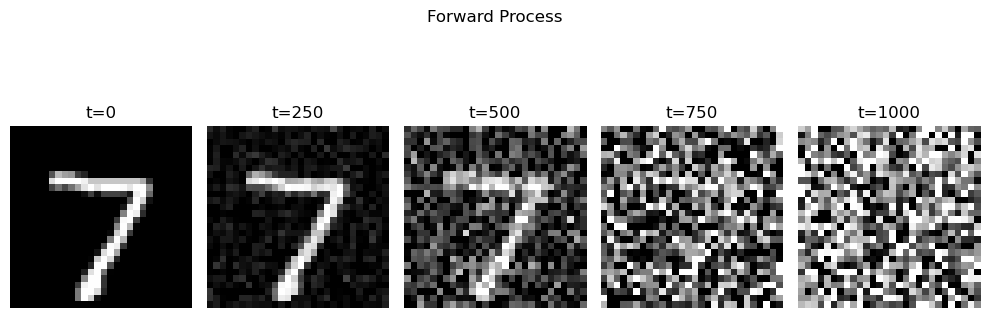

In [28]:
# Plot the samples
x, _ = next(iter(test_loader_mnist))
plot_forward_process(diffusion_model_mnist, x, [0, T//4, T//2, T*3//4, T], title='Forward Process', cmap='gray', denormalize=True)

### Plot reverse process

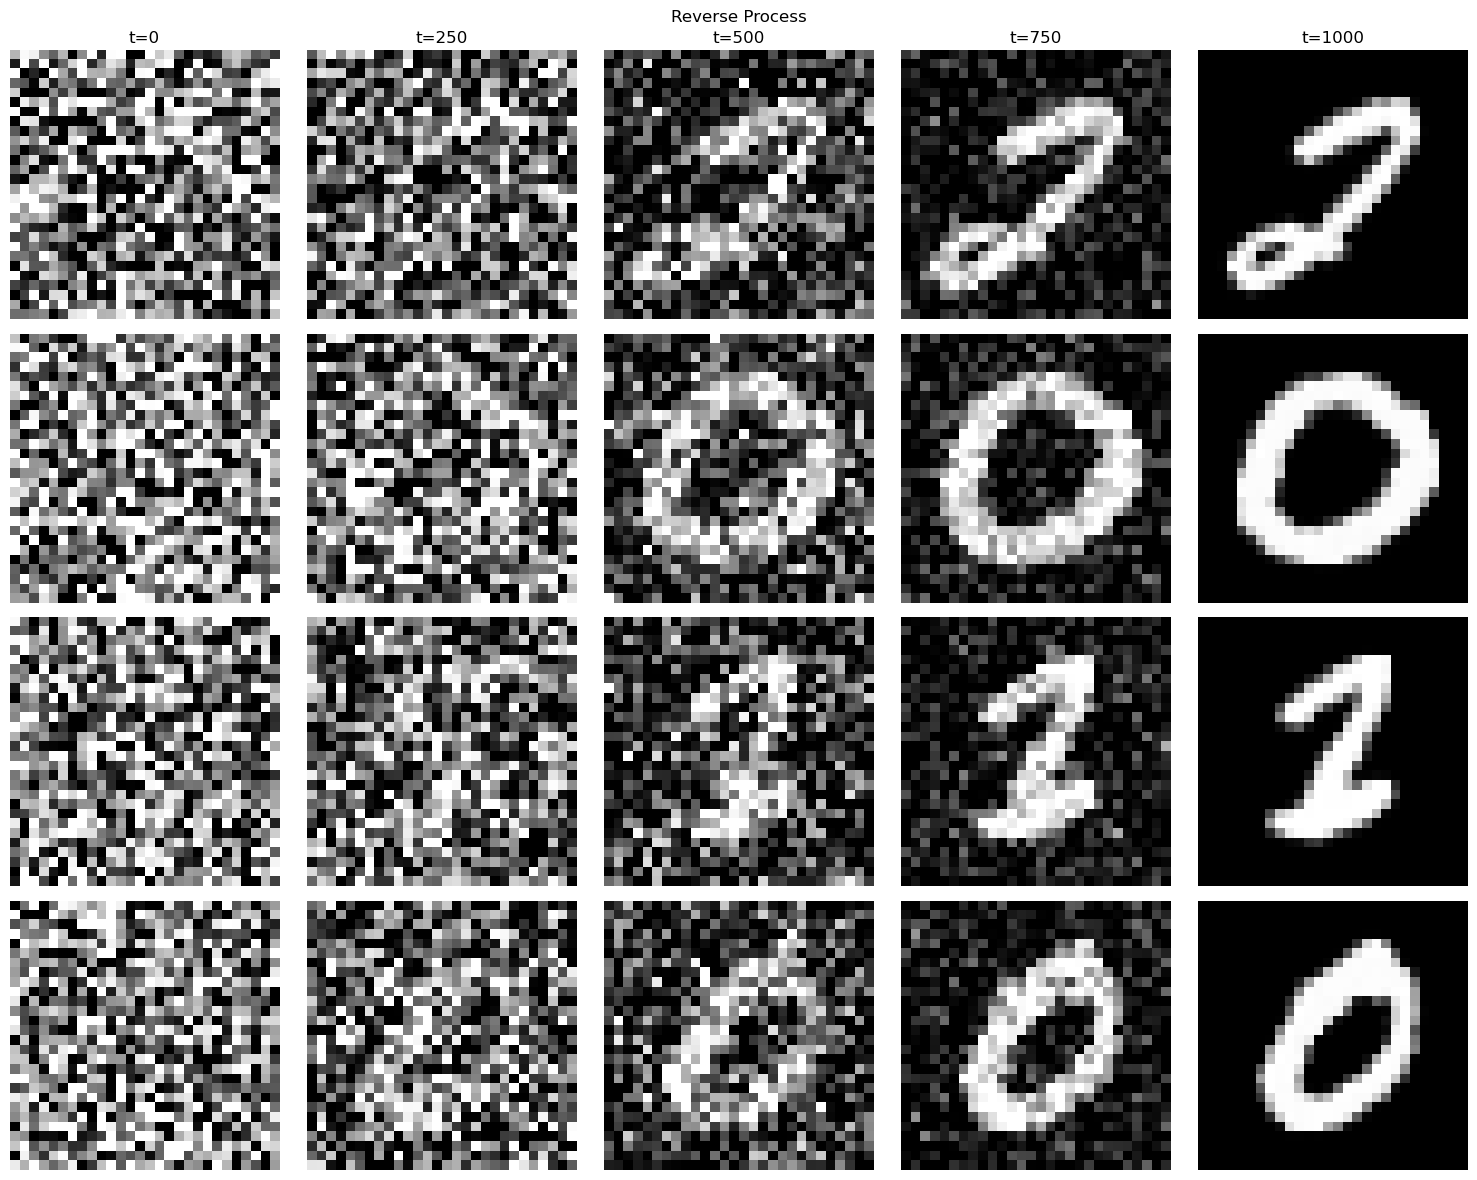

In [29]:
samples = diffusion_model_mnist.all_step_sample(n_samples=4)
plot_reverse_process(samples, [0, T//4, T//2, T*3//4, T], title='Reverse Process', cmap='gray', denormalize=True)

### Generate some image samples

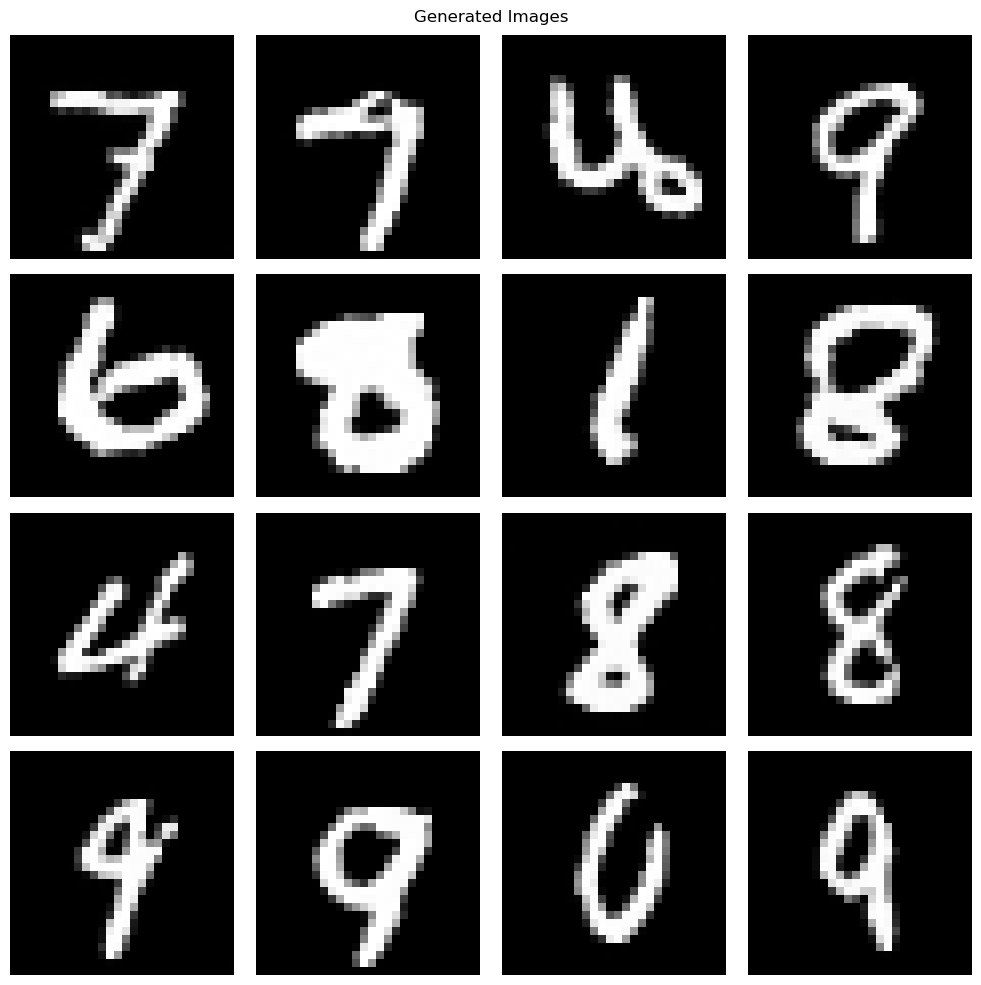

In [33]:
# Sample from the model
samples = diffusion_model_mnist.sample(n_samples=16)
plot_multiple_images(samples, title='Generated Images', cmap='gray', denormalize=True)

## CIFAR10

### Initialize the datasets

In [7]:
train_loader_cifar10, val_loader_cifar10, test_loader_cifar10 = data_module.get_CIFAR10_data_split(
    batch_size=128,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
)

Files already downloaded and verified
Files already downloaded and verified


### Initialize the  best performing model for CIFAR10 which was with no Attention blocks and a Linear schedule

In [8]:
model_path_cifar10 = os.path.join(PROJECT_BASE_DIR, "resources", "saved_models","cifar10", "cifar10_unet.pth")

In [9]:
# Initialize diffusion model
T =1000 
model_cifar10 = SimpleModel(ch_layer0=64, out_ch=3, num_layers=3, num_res_blocks_per_layer=2, layer_ids_with_attn=[], dropout=0.1, resamp_with_conv= True)
schedule_linear = LinearSchedule(10e-4, 0.02, T)
diffusion_model_cifar10 = DiffusionModel(model_cifar10, T=T, schedule=schedule_linear, img_shape=(3, 32, 32))
diffusion_model_cifar10.load(model_path_cifar10)
model_cifar10.to(device)

Model loaded from c:\Users\zeljk\Documents\DTU\DeepLearning\DenoisingDiffusionModels\02456_Group_44_DDPM_Project\resources\saved_models\cifar10\cifar10_unet.pth


SimpleModel(
  (temb_dense0): Linear(in_features=64, out_features=256, bias=True)
  (temb_dense1): Linear(in_features=256, out_features=256, bias=True)
  (conv_in): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0-1): 2 x ResNetBlock(
      (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (temb_proj): Linear(in_features=256, out_features=64, bias=True)
      (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (2): Downsample(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (3-4): 2 x ResNetBlock(
      (norm1): GroupNorm(64, 128, eps=1e-05, affine=True)
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (temb_

### Plot the forward process

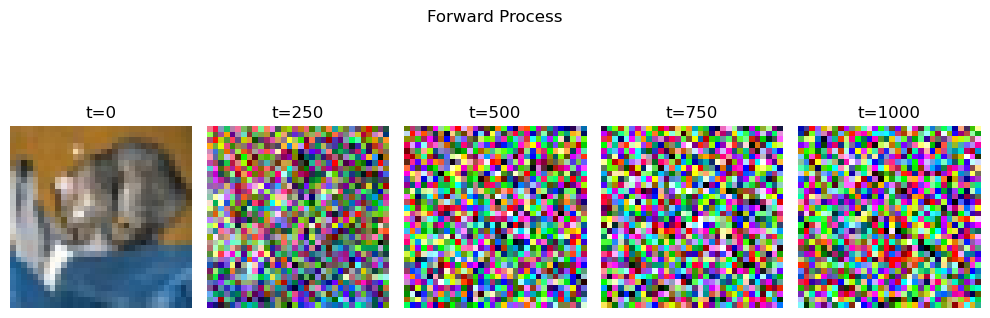

In [37]:
# Plot the samples
x, _ = next(iter(test_loader_cifar10))
plot_forward_process(diffusion_model_cifar10, x, [0, T//4, T//2, T*3//4, T], title='Forward Process', cmap=None, denormalize=True)

### Plot the reverse process

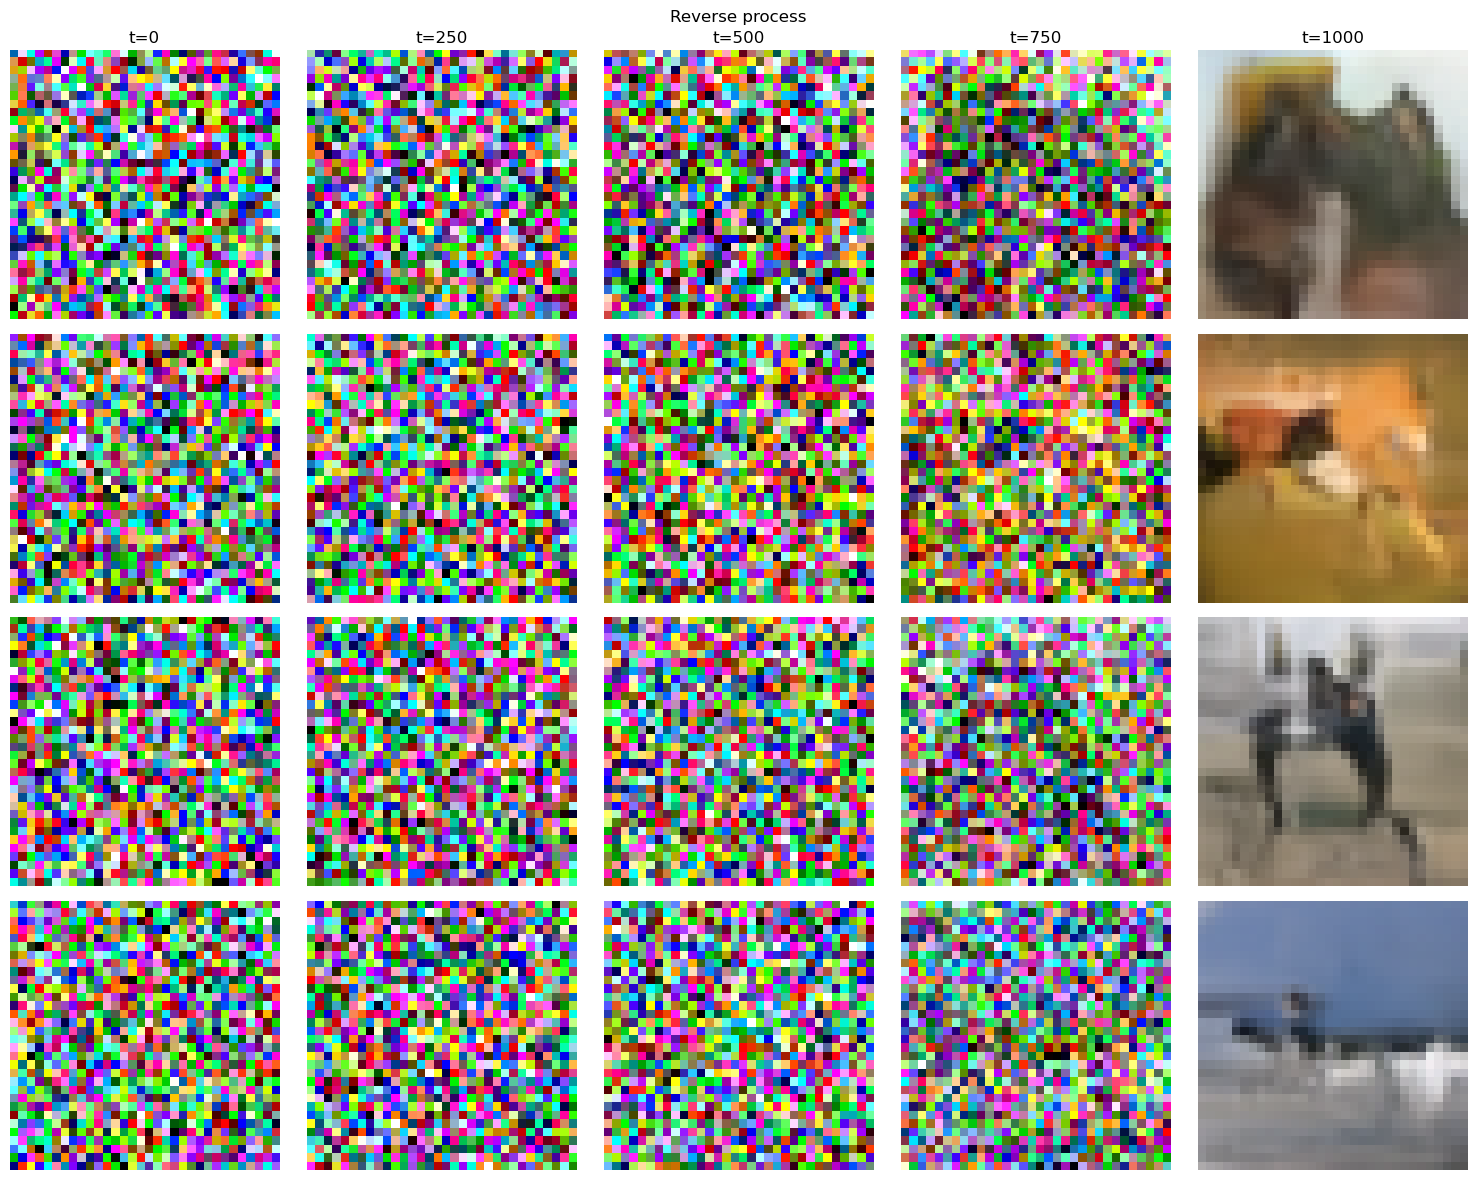

In [30]:
samples = diffusion_model_cifar10.all_step_sample(n_samples=4)
plot_reverse_process(samples, [0, T//4, T//2, T*3//4, T], title="Reverse process", cmap=None, denormalize=True)

### Generate some image samples

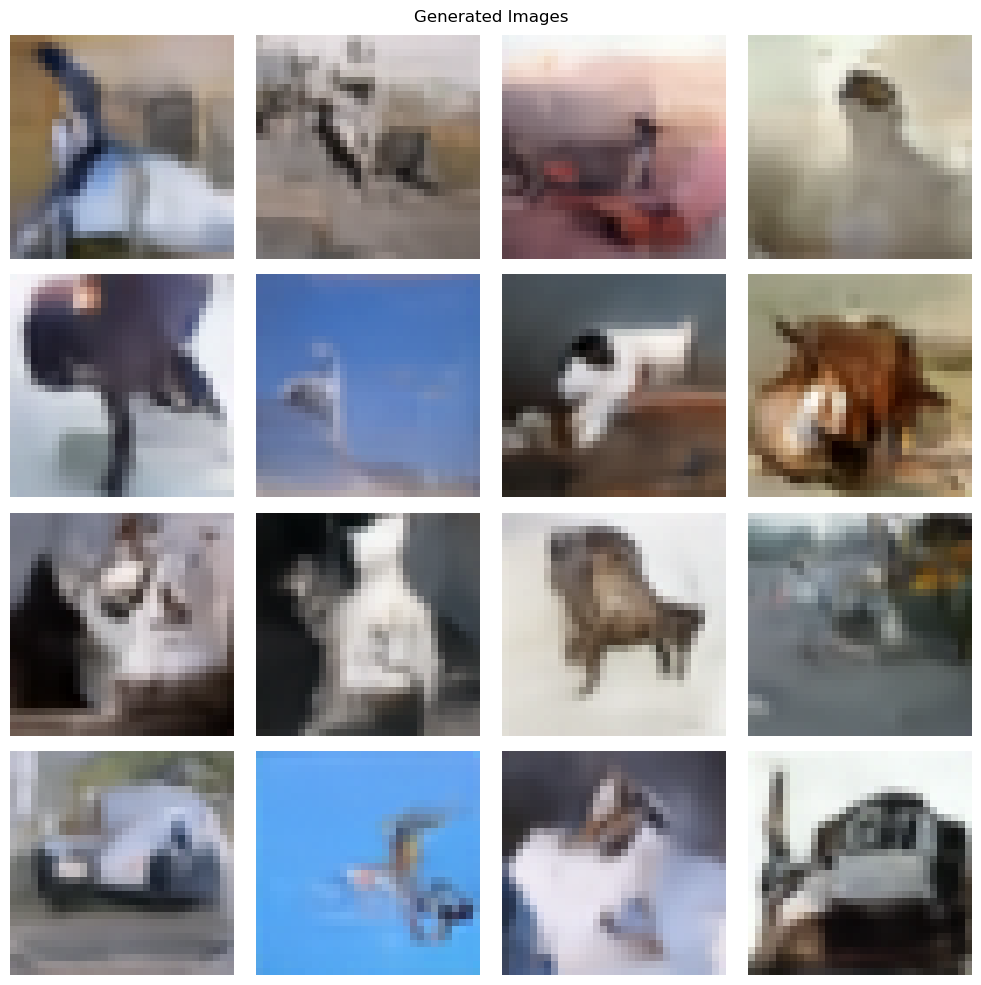

In [39]:
# Sample from the model
samples = diffusion_model_cifar10.sample(n_samples=16)
plot_multiple_images(samples, title='Generated Images', cmap=None, denormalize=True)

## Guided sampling

In this section we show our results utilizing guided sampling. We tried out 2 different approaches for this. One approach was to utilize a trained classifier to guide our sampling process, and another was to embedd class labels into our network and train this new model with additional embeddings.

To generate a desired class just change the *desired_class* variable in sampling cells.

### 1. Classifier guidance for sampling on MNIST and CIFAR10

In [10]:
classifier_mnist = MNISTGuidanceClassifier()
classifier_mnist.load_state_dict(torch.load(os.path.join(os.path.dirname(os.getcwd()),'resources','saved_models', 'mnist', 'mnist_guidance_classifier.pth'), weights_only=True))
T=1000
schedule_cosine = LinearSchedule(10e-4, 0.02, T)
model_mnist_linear = model = SimpleModel(ch_layer0=64, out_ch=1, num_layers=3, num_res_blocks_per_layer=2, layer_ids_with_attn=[], dropout=0.1, resamp_with_conv= True)
model_mnist_linear_path = os.path.join(os.path.dirname(os.getcwd()), "resources", "saved_models", "mnist", "mnist_unet_linear.pth")
diffusion_model_cg_mnist = DiffClassifierGuidance(model_mnist_linear, T=T, schedule=schedule_cosine, img_shape=(1, 28, 28), classifier=classifier_mnist, lambda_guidance=200)
diffusion_model_cg_mnist.load(model_mnist_linear_path)
model_mnist_linear.to(device)

Model loaded from c:\Users\zeljk\Documents\DTU\DeepLearning\DenoisingDiffusionModels\02456_Group_44_DDPM_Project\resources\saved_models\mnist\mnist_unet_linear.pth


SimpleModel(
  (temb_dense0): Linear(in_features=64, out_features=256, bias=True)
  (temb_dense1): Linear(in_features=256, out_features=256, bias=True)
  (conv_in): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0-1): 2 x ResNetBlock(
      (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (temb_proj): Linear(in_features=256, out_features=64, bias=True)
      (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (2): Downsample(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (3-4): 2 x ResNetBlock(
      (norm1): GroupNorm(64, 128, eps=1e-05, affine=True)
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (temb_

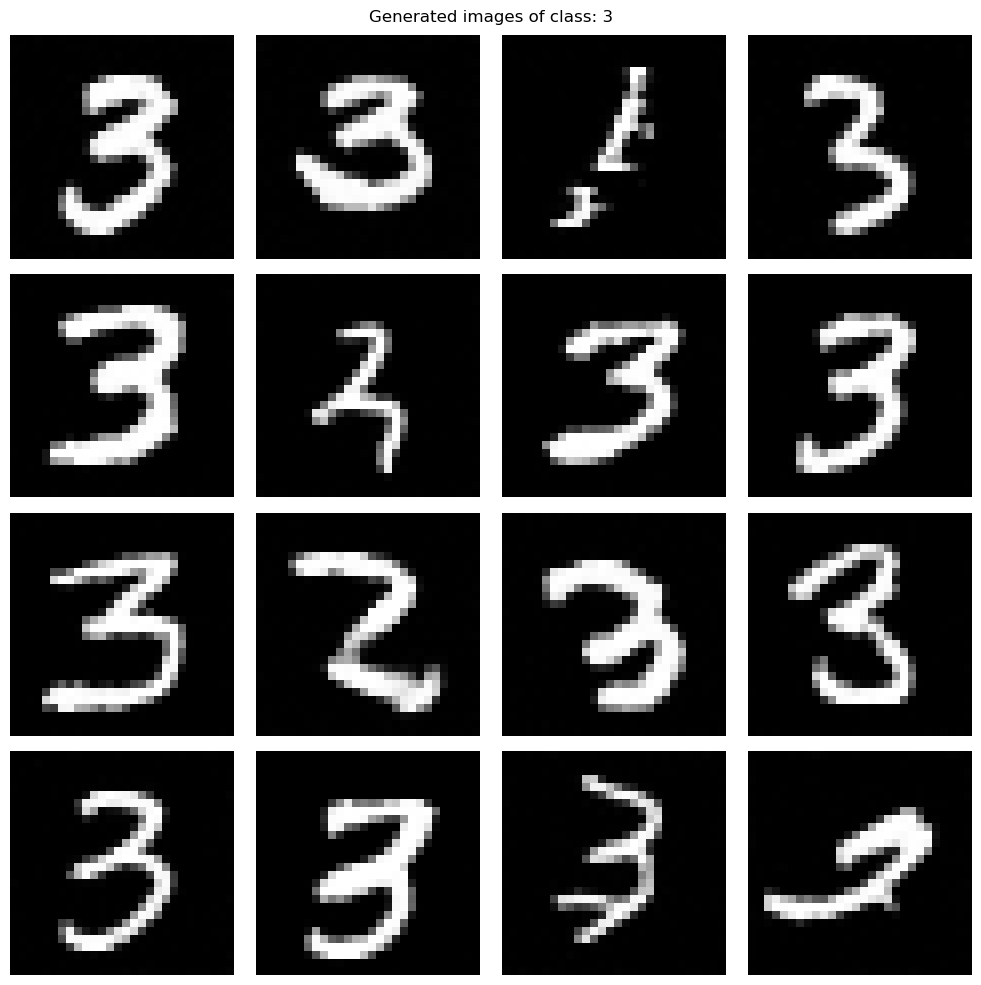

In [61]:
desired_class = 3
samples = diffusion_model_cg_mnist.sample(n_samples=16, class_label=desired_class)
plot_multiple_images(samples, title=f'Generated images of class: {desired_class}', cmap='gray', denormalize=True)

In [14]:
classifier_cifar10 = CIFAR10GuidanceClassifier()
classifier_cifar10.load_state_dict(torch.load(os.path.join(PROJECT_BASE_DIR,'resources','saved_models','cifar10','cifar10_guidance_classifier.pth'), weights_only=True))
T=1000
schedule_linear = LinearSchedule(10e-4, 0.02, T)
diffusion_model_cg_mnist = DiffClassifierGuidance(model_cifar10, T=T, schedule=schedule_linear, img_shape=(3, 32, 32), classifier=classifier_cifar10, lambda_guidance=200)

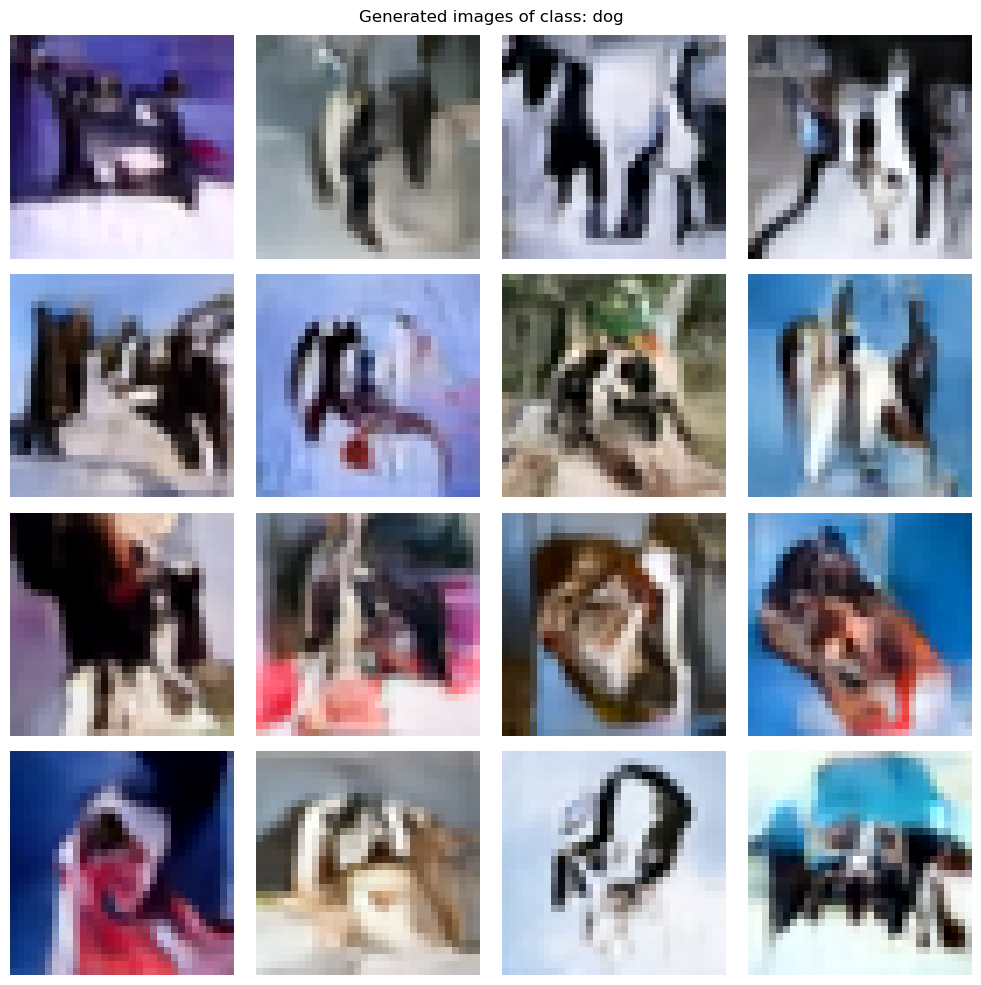

In [18]:
class_dict = {"airplane": 0, "automobile": 1, "bird": 2, "cat": 3, "deer": 4,
                  "dog": 5, "frog": 6, "horse": 7, "ship": 8, "truck": 9}
desired_class = "dog"
samples = diffusion_model_cg_mnist.sample(n_samples=16, class_label=class_dict[desired_class])
plot_multiple_images(samples, title=f'Generated images of class: {desired_class}', cmap='gray', denormalize=True)

### 2. Classifier-free guidance for MNIST

We have trained this model only for MNIST since we ran out of time to try it on CIFAR10.

In [24]:
model_mnist_cf = SimpleModelClassFreeGuidance(ch_layer0=4, out_ch=1, num_layers=2, num_res_blocks_per_layer=2, layer_ids_with_attn=[], dropout=0.1, resamp_with_conv= True, lambda_cf=1000.)
schedule_linear = LinearSchedule(10e-4, 0.02, T)
diffusion_model_mnist_cf = DiffClassifierFreeGuidance(model_mnist_cf, T=T, schedule=schedule_linear, img_shape=(1, 28, 28))
model_path_mnist_cf = os.path.join(PROJECT_BASE_DIR, "resources", "saved_models", "mnist", "mnist_unet_classifier_free.pth")
diffusion_model_mnist_cf.load(os.path.join(PROJECT_BASE_DIR, model_path_mnist_cf))

RuntimeError: Error(s) in loading state_dict for SimpleModelClassFreeGuidance:
	Missing key(s) in state_dict: "downs.1.norm1.weight", "downs.1.norm1.bias", "downs.1.conv1.weight", "downs.1.conv1.bias", "downs.1.temb_proj.weight", "downs.1.temb_proj.bias", "downs.1.norm2.weight", "downs.1.norm2.bias", "downs.1.conv2.weight", "downs.1.conv2.bias", "downs.1.shortcut_conv.weight", "downs.1.shortcut_conv.bias", "downs.2.conv.weight", "downs.2.conv.bias", "mid.1.norm1.weight", "mid.1.norm1.bias", "mid.1.conv1.weight", "mid.1.conv1.bias", "mid.1.temb_proj.weight", "mid.1.temb_proj.bias", "mid.1.norm2.weight", "mid.1.norm2.bias", "mid.1.conv2.weight", "mid.1.conv2.bias", "mid.1.shortcut_conv.weight", "mid.1.shortcut_conv.bias", "ups.2.norm1.weight", "ups.2.norm1.bias", "ups.2.conv1.weight", "ups.2.conv1.bias", "ups.2.temb_proj.weight", "ups.2.temb_proj.bias", "ups.2.norm2.weight", "ups.2.norm2.bias", "ups.2.conv2.weight", "ups.2.conv2.bias", "ups.2.shortcut_conv.weight", "ups.2.shortcut_conv.bias". 
	Unexpected key(s) in state_dict: "downs.3.conv.weight", "downs.3.conv.bias", "downs.4.norm1.weight", "downs.4.norm1.bias", "downs.4.conv1.weight", "downs.4.conv1.bias", "downs.4.temb_proj.weight", "downs.4.temb_proj.bias", "downs.4.norm2.weight", "downs.4.norm2.bias", "downs.4.conv2.weight", "downs.4.conv2.bias", "downs.4.shortcut_conv.weight", "downs.4.shortcut_conv.bias", "downs.5.norm.weight", "downs.5.norm.bias", "downs.5.q.weight", "downs.5.q.bias", "downs.5.k.weight", "downs.5.k.bias", "downs.5.v.weight", "downs.5.v.bias", "downs.5.proj_out.weight", "downs.5.proj_out.bias", "downs.6.norm1.weight", "downs.6.norm1.bias", "downs.6.conv1.weight", "downs.6.conv1.bias", "downs.6.temb_proj.weight", "downs.6.temb_proj.bias", "downs.6.norm2.weight", "downs.6.norm2.bias", "downs.6.conv2.weight", "downs.6.conv2.bias", "downs.6.shortcut_conv.weight", "downs.6.shortcut_conv.bias", "downs.7.conv.weight", "downs.7.conv.bias", "downs.1.norm.weight", "downs.1.norm.bias", "downs.1.q.weight", "downs.1.q.bias", "downs.1.k.weight", "downs.1.k.bias", "downs.1.v.weight", "downs.1.v.bias", "downs.1.proj_out.weight", "downs.1.proj_out.bias", "downs.2.norm1.weight", "downs.2.norm1.bias", "downs.2.conv1.weight", "downs.2.conv1.bias", "downs.2.temb_proj.weight", "downs.2.temb_proj.bias", "downs.2.norm2.weight", "downs.2.norm2.bias", "downs.2.conv2.weight", "downs.2.conv2.bias", "downs.2.shortcut_conv.weight", "downs.2.shortcut_conv.bias", "mid.2.norm1.weight", "mid.2.norm1.bias", "mid.2.conv1.weight", "mid.2.conv1.bias", "mid.2.temb_proj.weight", "mid.2.temb_proj.bias", "mid.2.norm2.weight", "mid.2.norm2.bias", "mid.2.conv2.weight", "mid.2.conv2.bias", "mid.2.shortcut_conv.weight", "mid.2.shortcut_conv.bias", "mid.1.norm.weight", "mid.1.norm.bias", "mid.1.q.weight", "mid.1.q.bias", "mid.1.k.weight", "mid.1.k.bias", "mid.1.v.weight", "mid.1.v.bias", "mid.1.proj_out.weight", "mid.1.proj_out.bias", "ups.4.norm1.weight", "ups.4.norm1.bias", "ups.4.conv1.weight", "ups.4.conv1.bias", "ups.4.temb_proj.weight", "ups.4.temb_proj.bias", "ups.4.norm2.weight", "ups.4.norm2.bias", "ups.4.conv2.weight", "ups.4.conv2.bias", "ups.4.shortcut_conv.weight", "ups.4.shortcut_conv.bias", "ups.5.conv.weight", "ups.5.conv.bias", "ups.6.norm1.weight", "ups.6.norm1.bias", "ups.6.conv1.weight", "ups.6.conv1.bias", "ups.6.temb_proj.weight", "ups.6.temb_proj.bias", "ups.6.norm2.weight", "ups.6.norm2.bias", "ups.6.conv2.weight", "ups.6.conv2.bias", "ups.6.shortcut_conv.weight", "ups.6.shortcut_conv.bias", "ups.7.norm.weight", "ups.7.norm.bias", "ups.7.q.weight", "ups.7.q.bias", "ups.7.k.weight", "ups.7.k.bias", "ups.7.v.weight", "ups.7.v.bias", "ups.7.proj_out.weight", "ups.7.proj_out.bias", "ups.8.norm1.weight", "ups.8.norm1.bias", "ups.8.conv1.weight", "ups.8.conv1.bias", "ups.8.temb_proj.weight", "ups.8.temb_proj.bias", "ups.8.norm2.weight", "ups.8.norm2.bias", "ups.8.conv2.weight", "ups.8.conv2.bias", "ups.8.shortcut_conv.weight", "ups.8.shortcut_conv.bias", "ups.9.norm1.weight", "ups.9.norm1.bias", "ups.9.conv1.weight", "ups.9.conv1.bias", "ups.9.temb_proj.weight", "ups.9.temb_proj.bias", "ups.9.norm2.weight", "ups.9.norm2.bias", "ups.9.conv2.weight", "ups.9.conv2.bias", "ups.9.shortcut_conv.weight", "ups.9.shortcut_conv.bias", "ups.2.norm.weight", "ups.2.norm.bias", "ups.2.q.weight", "ups.2.q.bias", "ups.2.k.weight", "ups.2.k.bias", "ups.2.v.weight", "ups.2.v.bias", "ups.2.proj_out.weight", "ups.2.proj_out.bias". 
	size mismatch for temb_dense0.weight: copying a param with shape torch.Size([128, 32]) from checkpoint, the shape in current model is torch.Size([16, 4]).
	size mismatch for temb_dense0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for temb_dense1.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([16, 16]).
	size mismatch for temb_dense1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for downs.0.norm1.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for downs.0.norm1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for downs.0.conv1.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([4, 4, 3, 3]).
	size mismatch for downs.0.conv1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for downs.0.temb_proj.weight: copying a param with shape torch.Size([32, 128]) from checkpoint, the shape in current model is torch.Size([4, 16]).
	size mismatch for downs.0.temb_proj.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for downs.0.norm2.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for downs.0.norm2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for downs.0.conv2.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([4, 4, 3, 3]).
	size mismatch for downs.0.conv2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for downs.0.shortcut_conv.weight: copying a param with shape torch.Size([32, 32, 1, 1]) from checkpoint, the shape in current model is torch.Size([4, 4, 1, 1]).
	size mismatch for downs.0.shortcut_conv.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for mid.0.norm1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for mid.0.norm1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for mid.0.conv1.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([8, 8, 3, 3]).
	size mismatch for mid.0.conv1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for mid.0.temb_proj.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([8, 16]).
	size mismatch for mid.0.temb_proj.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for mid.0.norm2.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for mid.0.norm2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for mid.0.conv2.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([8, 8, 3, 3]).
	size mismatch for mid.0.conv2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for mid.0.shortcut_conv.weight: copying a param with shape torch.Size([128, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([8, 8, 1, 1]).
	size mismatch for mid.0.shortcut_conv.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for ups.0.conv.weight: copying a param with shape torch.Size([64, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([4, 8, 3, 3]).
	size mismatch for ups.0.conv.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for ups.1.norm1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for ups.1.norm1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for ups.1.conv1.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([8, 8, 3, 3]).
	size mismatch for ups.1.conv1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for ups.1.temb_proj.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([8, 16]).
	size mismatch for ups.1.temb_proj.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for ups.1.norm2.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for ups.1.norm2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for ups.1.conv2.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([8, 8, 3, 3]).
	size mismatch for ups.1.conv2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for ups.1.shortcut_conv.weight: copying a param with shape torch.Size([128, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([8, 8, 1, 1]).
	size mismatch for ups.1.shortcut_conv.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for ups.3.norm1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for ups.3.norm1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for ups.3.conv1.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([8, 8, 3, 3]).
	size mismatch for ups.3.conv1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for ups.3.temb_proj.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([8, 16]).
	size mismatch for ups.3.temb_proj.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for ups.3.norm2.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for ups.3.norm2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for ups.3.conv2.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([8, 8, 3, 3]).
	size mismatch for ups.3.conv2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for ups.3.shortcut_conv.weight: copying a param with shape torch.Size([128, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([8, 8, 1, 1]).
	size mismatch for ups.3.shortcut_conv.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for norm_out.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for norm_out.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for conv_out.weight: copying a param with shape torch.Size([1, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([1, 8, 3, 3]).
	size mismatch for label_embedding.weight: copying a param with shape torch.Size([10, 128]) from checkpoint, the shape in current model is torch.Size([10, 16]).